# College Basketball Data Clustering Project

**Names**: Miles Mathews (Put your name here!)

## 1. Introduction and Dataset Research

Basketball is a very complex and interesting sport that features many different statistics. There are points, assists, blocks, steals, and so much more. But what about these are important? Which ones matter?

We were able to pull the college stats of many different players since 2003 from big Ten schools. In addition, we were able to pull different NBA players as well. We wanted to find the underlying reasons different college basketball players were able to get into the NBA and what statistics about a player were targeted. We outlined the questions for our research below:

Question 1: What are the qualities of a NBA basketball player? Should they have the most points, be the most dominant on the court, and carry every team to victory?

Question 2: How has the role of a Guard, Forward, and Center changed? What underlying clusters about the dataset tell us about these positions? For example, historically, the guards pass, shoot, and bring the ball up down the court while centers stay in the post and grab rebounds. However, with the change in how basketball is being played, the lines in between each role is beginning to blur.

## 2. Data Cleaning and Data Manipulation

In [2]:
#Import statements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from scipy.spatial.distance import pdist, squareform
from skfuzzy.cluster import cmeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA

In [30]:
#Our datasets

nba = pd.read_csv('nba_players.csv')
cbb = pd.read_csv('college_players.csv')

In [31]:
#Names of the nba players

nba_names = nba['name'].to_list()

In [32]:
#Data Cleaning and Manipulation Functions

def f(x):
    if x in nba_names:
        return 1
    return 0

def h(x):
    if x not in ['Guard', 'Forward', 'Center']:
        return 'Unknown'
    return x

def g(x):
    if x == 'Unknown':
        return 0
    x = x.split('-')
    return 12*int(x[0]) + int(x[1])

def i(x):
    return int(x)

In [33]:
cbb['nba'] = cbb['name'].apply(f)
cbb['position'] = cbb['position'].fillna('Unknown')
cbb['position'] = cbb['position'].apply(h)
cbb['height'] = cbb['height'].apply(g)

cbb = cbb.drop(cbb[cbb['weight'] == 'Unknown'].index, axis=0).reset_index()
cbb = cbb.drop(cbb[cbb['position'] == 'Unknown'].index, axis=0).reset_index()
cbb = cbb.drop(['Unnamed: 0', 'name'], axis=1)

cbb['weight'] = cbb['weight'].apply(i)

In [34]:
cbb.head()

,level_0,index,height,weight,position,games_played,min_per,field_goal,field_attmps,two_pointer,...,personal_fouls,usg,off_reb,def_reb,total_reb,player_eff,tv_per_game,ws,bpm,nba
0,0,0,76,175,Guard,144,0,3.2,7.3,2.1,...,1.7,17.5,2.6,9.8,2.8,14.800,9.5,13.200,4.7,0
1,1,1,76,195,Guard,139,0,1.8,4.0,1.2,...,1.0,15.3,2.9,7.0,1.5,12.400,14.2,7.300,4.1,0
2,3,3,80,221,Forward,118,0,2.0,5.3,0.9,...,1.4,20.5,3.5,11.7,2.3,11.000,11.1,3.100,-1.0,0
3,4,4,78,200,Forward,120,0,3.5,7.3,2.6,...,2.6,0.0,0.0,8.2,4.0,0.592,18.2,0.144,0.0,0
4,5,5,74,185,Guard,138,0,2.9,7.5,2.0,...,2.2,21.4,2.5,12.3,3.1,13.700,17.3,8.300,2.8,0


First, we upload the datasets of college basketball stats and NBA stats. Followed by this, we begin cleaning and manipulating the data by introducing different functions to apply on our datasets. We clean the position, height, and weight columns, and drop players with 'Unknown' data. These players either weren't grabbed correctly by our web scraper or the information from the website we used to scrape from was incomplete.

Next, we look at the columns of the dataset and see if things make sense. Only one column seems off, the minutes per game column, which we will likely need to remove.

## 3. Basic Descriptive Analytics

Before we go into a deeper dive on the information, we want to set up what some of these advanced basketball statisitcs might mean:

ws: Win shares is a metric that estimates the number of wins a player produces for his team throughout the season.

bpm: Box Plus-Minus is a metric that evaluates a basketball players' quality and contribution to the team from each play.

field_goal: Field goals are the total number of shots made (not points).

usg: Usage relate to the percentage of team plays a player was involved in, while they were on the floor.

total_reb: Total rebounds refer to the number of rebounds a player achieved in a game on average.

In [7]:
nba = cbb[cbb.nba == 1]
not_nba = cbb[cbb.nba == 0]

In [8]:
nba.describe()

,height,weight,games_played,min_per,field_goal,field_attmps,two_pointer,two_pct,three_ptrs,three_pct,...,personal_fouls,usg,off_reb,def_reb,total_reb,player_eff,tv_per_game,ws,bpm,nba
count,200.000000,200.000000,200.00000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,78.960000,218.275000,87.33500,0.0,4.065000,8.495000,3.162000,0.523490,0.901500,0.300490,...,2.111000,17.219500,6.335000,14.675500,4.998500,15.992740,16.127000,7.190300,25.447500,1.0
std,3.279049,25.264617,38.11333,0.0,1.262953,2.814013,1.238031,0.056914,0.763783,0.139844,...,0.481809,9.919017,5.431582,5.790796,1.961091,9.338155,5.688591,5.797292,168.813199,0.0
min,69.000000,155.000000,14.00000,0.0,0.700000,1.500000,0.300000,0.374000,0.000000,0.000000,...,0.600000,0.000000,0.000000,0.000000,1.300000,0.511000,0.000000,0.114000,-0.200000,1.0
25%,77.000000,200.000000,55.75000,0.0,3.300000,6.600000,2.300000,0.484000,0.175000,0.271750,...,1.800000,15.525000,1.800000,10.375000,3.400000,13.025000,12.175000,1.450000,2.375000,1.0
50%,79.000000,215.000000,94.50000,0.0,4.000000,8.400000,3.000000,0.521500,0.800000,0.343500,...,2.100000,20.900000,5.000000,14.100000,4.800000,18.650000,15.300000,6.400000,6.400000,1.0
75%,82.000000,237.250000,122.00000,0.0,4.900000,10.300000,3.900000,0.565000,1.500000,0.377250,...,2.425000,23.825000,10.325000,18.425000,6.025000,22.600000,18.625000,11.350000,8.400000,1.0
max,85.000000,275.000000,152.00000,0.0,7.600000,17.200000,7.000000,0.746000,3.100000,1.000000,...,3.400000,32.200000,25.400000,31.200000,10.400000,35.100000,34.600000,22.200000,1685.000000,1.0


In [9]:
not_nba.describe()

,height,weight,games_played,min_per,field_goal,field_attmps,two_pointer,two_pct,three_ptrs,three_pct,...,personal_fouls,usg,off_reb,def_reb,total_reb,player_eff,tv_per_game,ws,bpm,nba
count,1508.000000,1508.000000,1508.000000,1508.0,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,...,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.0
mean,77.070292,208.666446,74.312997,0.0,1.793103,4.118568,1.299403,0.438278,0.493037,0.238973,...,1.348077,13.524271,4.713064,12.039920,2.384947,8.740736,17.219496,3.163792,26.534019,0.0
std,5.685203,26.201091,45.903206,0.0,1.478855,3.306299,1.178172,0.180301,0.598925,0.178698,...,0.823028,9.762200,5.992126,6.982473,1.812760,9.340796,9.584619,4.242254,164.268700,0.0
min,0.000000,145.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-46.700000,0.000000,-0.784000,-57.000000,0.0
25%,75.000000,190.000000,30.750000,0.0,0.400000,1.000000,0.300000,0.409000,0.000000,0.000000,...,0.600000,0.000000,0.000000,8.200000,0.800000,0.534750,12.800000,0.076000,-0.600000,0.0
50%,77.000000,205.000000,76.000000,0.0,1.600000,3.500000,1.100000,0.471000,0.200000,0.297000,...,1.500000,16.000000,3.100000,11.500000,2.200000,10.200000,16.400000,0.600000,0.200000,0.0
75%,80.000000,225.000000,118.000000,0.0,2.800000,6.400000,2.000000,0.525000,0.800000,0.354000,...,2.000000,20.600000,7.700000,15.300000,3.425000,15.300000,20.600000,5.700000,3.725000,0.0
max,88.000000,314.000000,179.000000,0.0,6.600000,14.500000,6.600000,1.000000,3.000000,1.000000,...,3.500000,57.000000,100.000000,100.000000,11.700000,53.700000,100.000000,21.000000,2088.000000,0.0


Here we can see that there are some differences between the two datasets above. We decided to do a holistic review of NBA players to see which stats are significantly higher on average compared to non-NBA players. We see these distances in a few categories: field goals, field goal attempts, percentage of three and two pointers, total rebounds, higher player efficiency rating, and win shares (ws). We can look at how these interact and determine if they are worth clustering around in a pair plot.

In [35]:
cols_to_drop = ['height', 'weight', 'min_per', 'position', 'games_played', 'two_pointer', 'three_ptrs', 'free_throws', 'personal_fouls', 'assists', 'steals', 'blocks', 'off_reb', 'def_reb', 'tv_per_game', 'bpm']

cbb_copy = cbb.copy()
cbb_copy = cbb_copy.drop(cols_to_drop, axis=1)

In [36]:
cbb_copy.head()

,level_0,index,field_goal,field_attmps,two_pct,three_pct,free_pct,points,usg,total_reb,player_eff,ws,nba
0,0,0,3.2,7.3,0.499,0.366,0.754,9.1,17.5,2.8,14.800,13.200,0
1,1,1,1.8,4.0,0.486,0.401,0.754,5.5,15.3,1.5,12.400,7.300,0
2,3,3,2.0,5.3,0.440,0.338,0.620,6.1,20.5,2.3,11.000,3.100,0
3,4,4,3.5,7.3,0.517,0.370,0.829,10.6,0.0,4.0,0.592,0.144,0
4,5,5,2.9,7.5,0.425,0.313,0.737,8.6,21.4,3.1,13.700,8.300,0


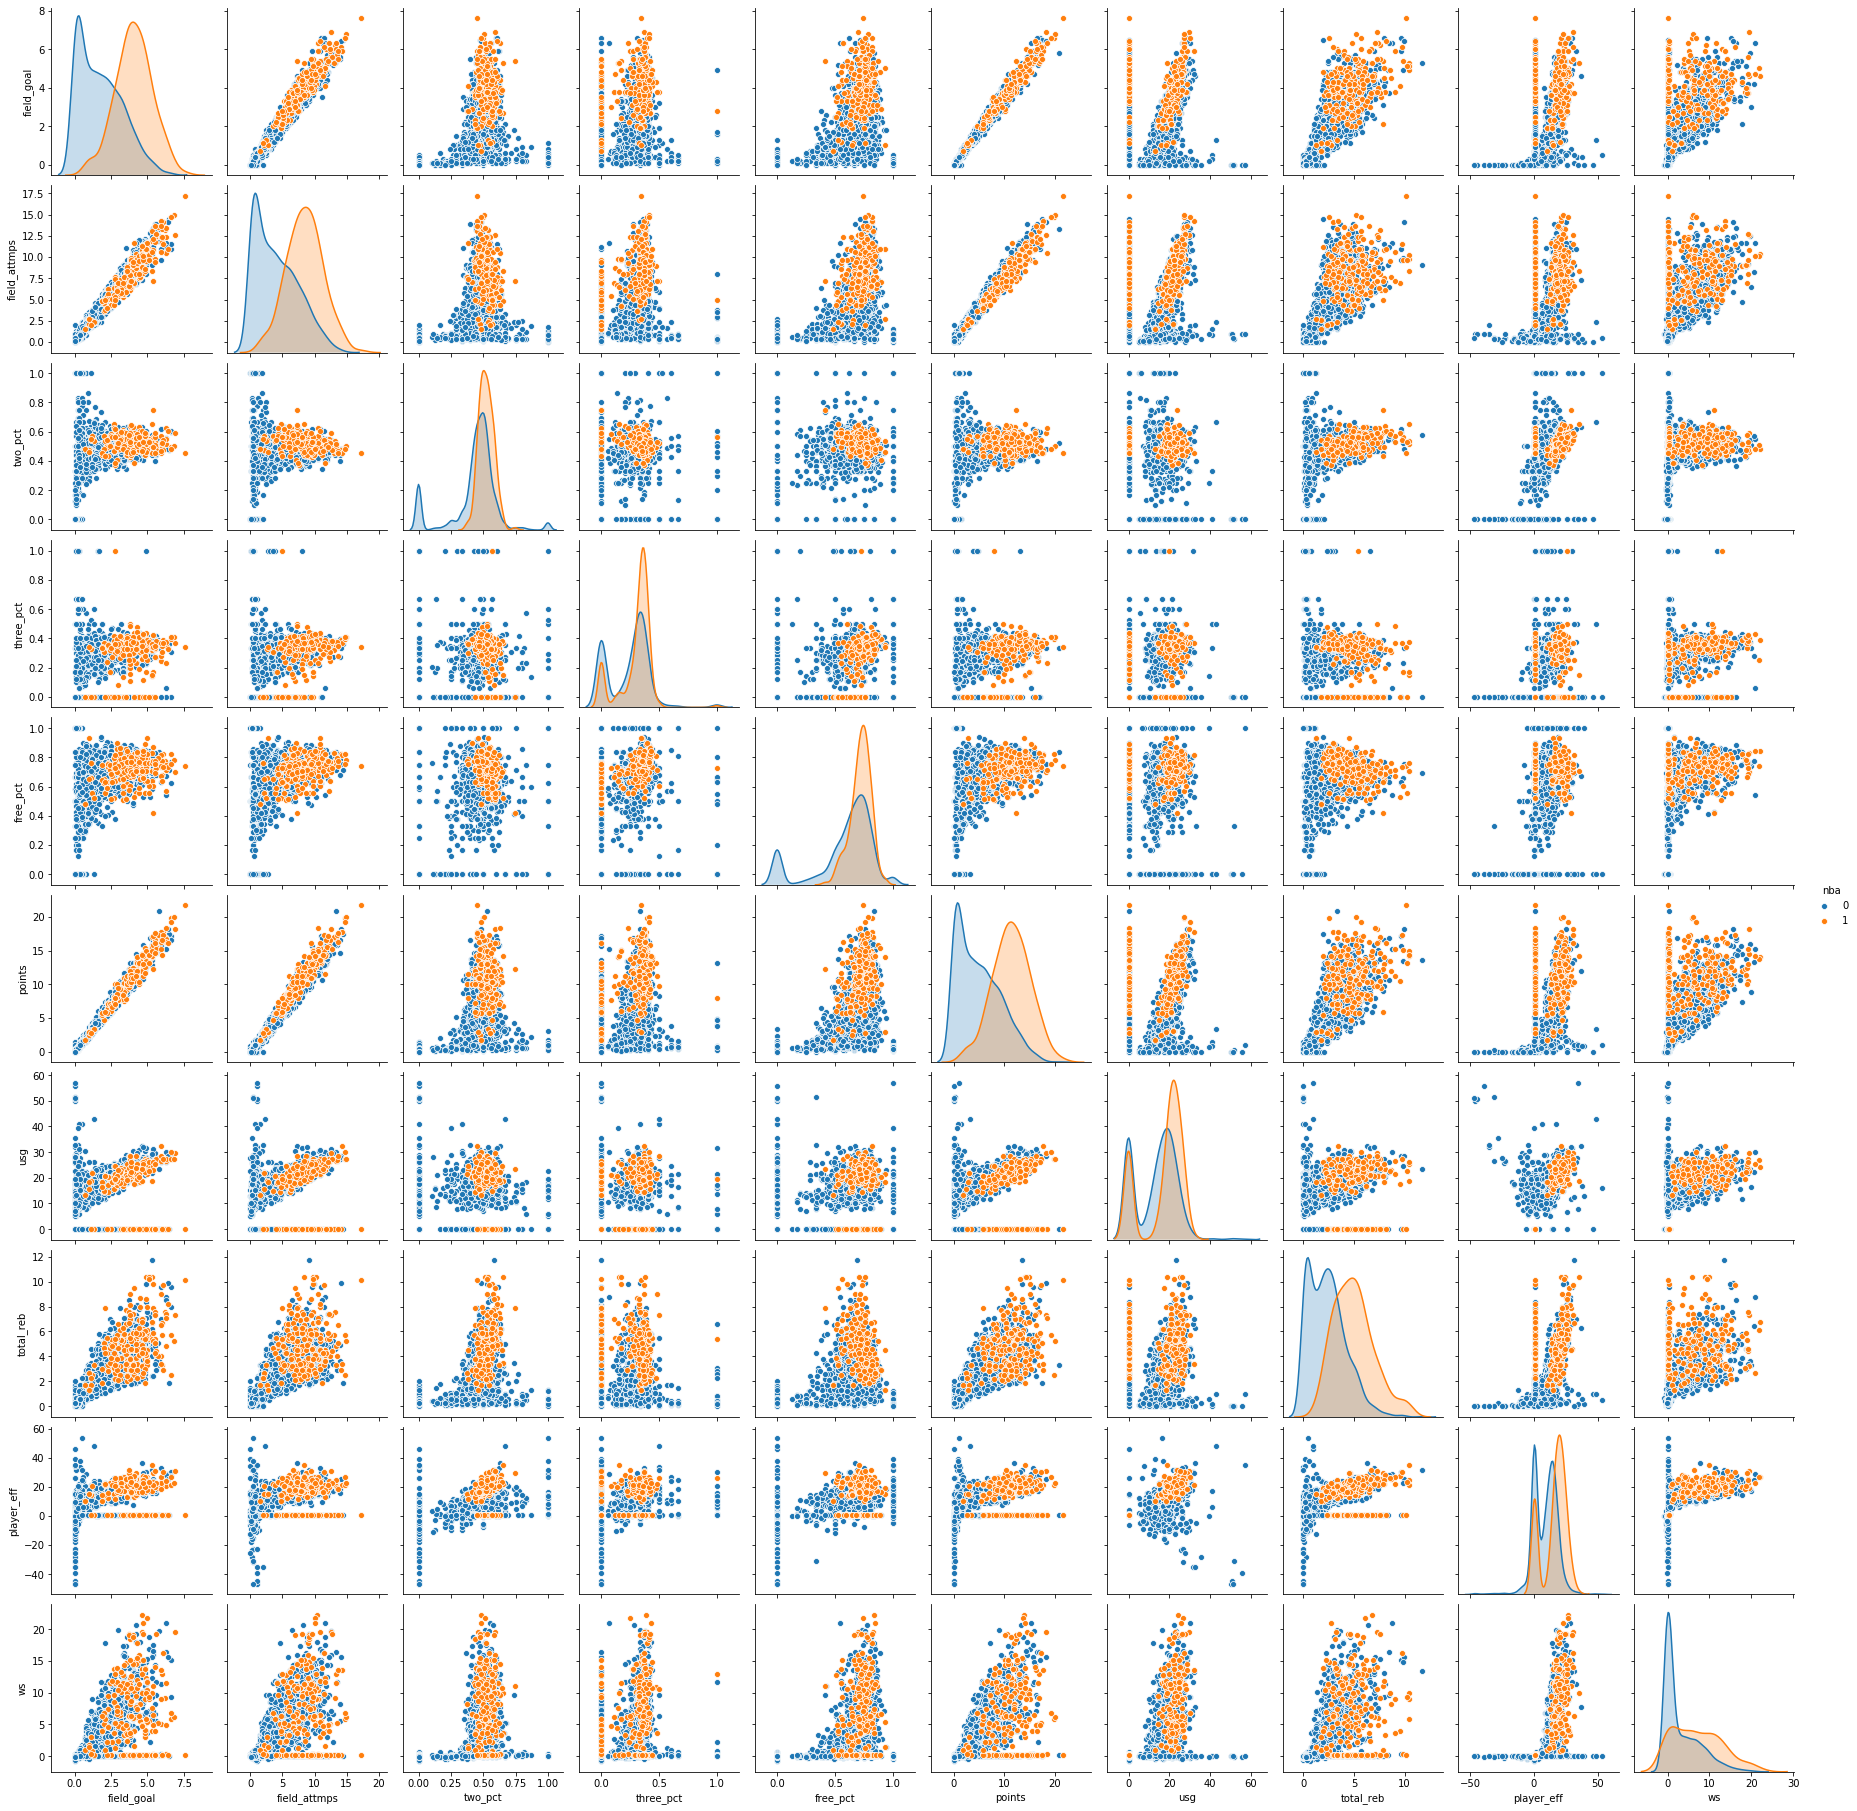

In [12]:
sns.pairplot(cbb_copy, hue='nba')
plt.show()

From these pair plots, we can look at the density plots and see how much separation there is between certain variables. The more separation the better because we are trying to look for differences between non-NBA players and NBA players in the dataset.

Something to note is that these variables have a lot of overlapping, which is good to know for the future.

## 4. Dataset Scaling Decisions

For the first stab at a clustering algorithm, we decided to scale the data to have a mean of 0, and remove the NBA feature, as it will be our ultimate target label

In [10]:
df = cbb_copy.copy()
df = df.drop(['nba'], axis=1)

In [11]:
X = StandardScaler(with_std=False).fit_transform(df)

df = pd.DataFrame(X, columns = df.columns)
sub_cols = df.columns.to_list()

In [12]:
df.head()

,field_goal,field_attmps,two_pct,three_pct,free_pct,points,usg,total_reb,player_eff,ws
0,1.140867,2.66897,0.050744,0.119823,0.149269,3.309309,3.543033,0.109016,5.210083,9.56472
1,-0.259133,-0.63103,0.037744,0.154823,0.149269,-0.290691,1.343033,-1.190984,2.810083,3.66472
2,-0.059133,0.66897,-0.008256,0.091823,0.015269,0.309309,6.543033,-0.390984,1.410083,-0.53528
3,1.440867,2.66897,0.068744,0.123823,0.224269,4.809309,-13.956967,1.309016,-8.997917,-3.49128
4,0.840867,2.86897,-0.023256,0.066823,0.132269,2.809309,7.443033,0.409016,4.110083,4.66472


## 5. Clusterability and Clustering Structure Questions

In [16]:
n=len(cbb_copy)
num_trials=5
hopkins_stats=[]
for i in range(0,num_trials):
    n = len(cbb_copy)
    p = int(0.1 * n)
    hopkins_stats.append(hopkins(cbb_copy,p))
print(hopkins_stats)

[0.08155680552010491, 0.07520545181873499, 0.07278724530943605, 0.07186140015019447, 0.07179031738865659]


So, we found that are dataset is pretty clusterable from the Hopkins statistic. All of our trials were near 0, which is a good sign. If they were high, our ability to cluster the data well would decrease.

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


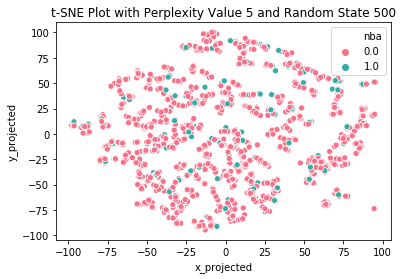

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


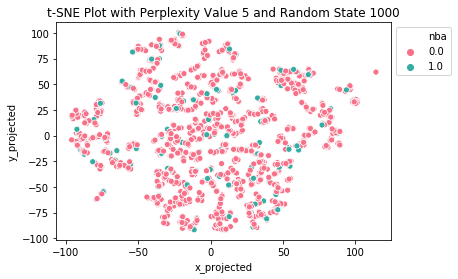

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


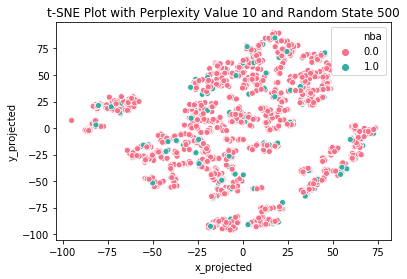

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


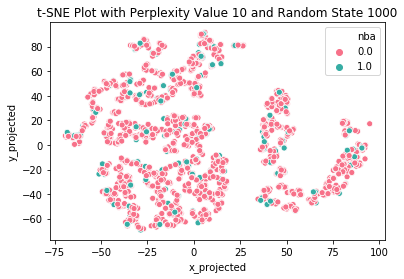

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


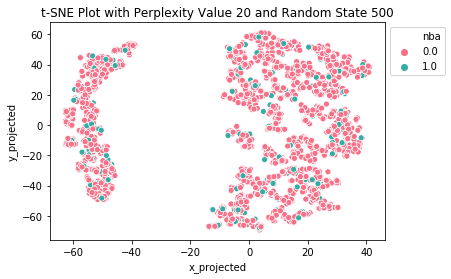

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


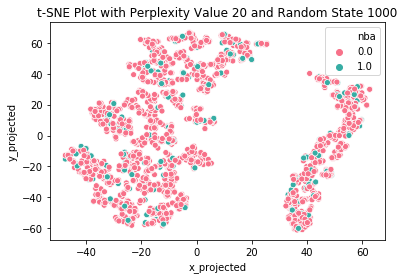

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


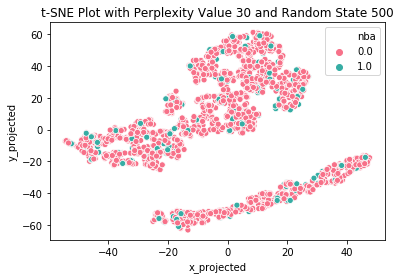

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


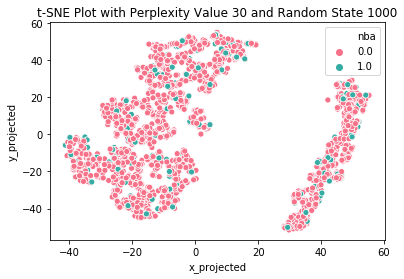

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


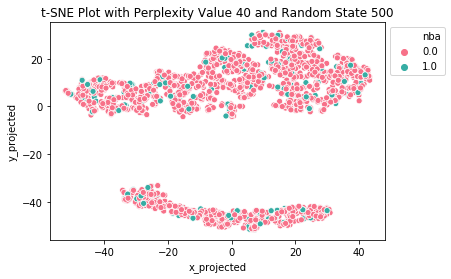

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


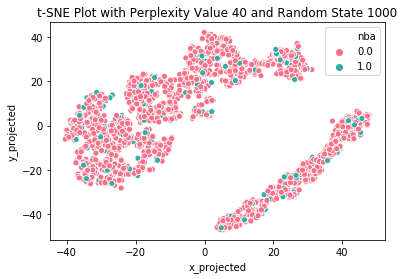

--------------------------------------------


/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


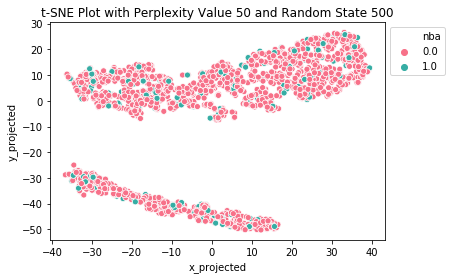

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


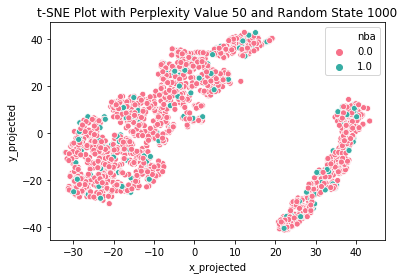

--------------------------------------------


In [17]:
for perp in [5,10, 20, 30, 40, 50]: 
    for rs in [500, 1000]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(X)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        df_combo['nba'] = cbb['nba']
        sns.scatterplot(x='x_projected',y='y_projected', hue='nba', palette=sns.color_palette("husl", 2), data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()
    print('--------------------------------------------')

After looking at these t-SNE plots, our clustering doesn't seem to follow most NBA players, so there must be some other clustering going on. However, we do see some spherical shapes with our dataset, so it seems like it can be clustered in some meaningful way.

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


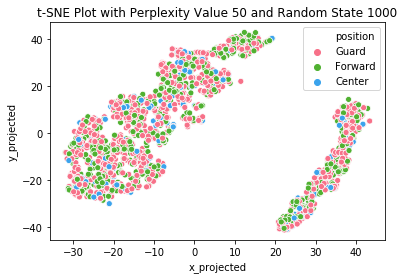

In [18]:
perp = 50
rs = 1000

tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df, df_tsne], axis=1)
df_combo['position'] = cbb['position']
sns.scatterplot(x='x_projected',y='y_projected', hue='position', palette=sns.color_palette("husl", 3), data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

We decided to redo the last t-SNE plot, but look at how and where the positions are in placed. Looking at this, the position of the players are very sparsed, showing that the clustering structure of players might not matter to much, which is what is currently happening in the NBA.

Here we identified the number of clusters to choose from for a K-Means implementation. The elbow plot seems to be pretty strong for around 4 clusters, but the impact isn't as sudden, so there could be more.

## 6. Algorithm Selection Motivation

First, we decied to use K-Means, as our data was spherical and this is the gold standard algorithm in clustering. We know it might not give us the information we want, but it's a good stepping stone to see what's being analyzed in the dataset.

Our second clustering algorithm is Fuzzy Clustering, since the acquisition of players can be very random. There are many factors that are important in calculating whether a college player will be able to go pro, but one of the most important factors is being lucky. Teams trade spots, and those teams might need certain types of players, which could not be the overall best. For example, a team might not need to acquire another guard, if you have a guard on your team; even if the best college player is a guard.

## 7. K-Means



### 7.1. Parameter Selection

k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11


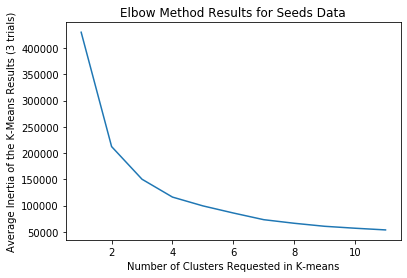

In [23]:
cluster_num_list=range(1,12)
avg_inertia_list=[]
for k in cluster_num_list:
    print('k= '+str(k))
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(X)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))
    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Seeds Data')
plt.show()

So there are a few things in mind for when we start clustering:

1. The number of clusters might not be the best as the we could have more clusters than to be expected.
2. We are looking at more than 2 clusters, which means our data will not be mapped onto whether they are in the NBA or not. Rather, we could be looking at clusters of data within each cluster. Meaning, we could be analyzing top NBA prospects that follow a certain stat spread and NBA players that barely get by in the league (i.e. benchwarmers).
3. We are also not looking at 3 clusters, which means the clusters will most likely not be mapped onto positions, which can be interesting to see what types of players follow what distribution.
4. The clusters might not be well separated, and if they aren't we need to see what's goint wrong with the dataset (i.e. outliers).

### 7.2. Clustering Algorithm

In [46]:
kmeans_one=KMeans(n_clusters=4).fit(X)
kmeans_two=KMeans(n_clusters=6).fit(X)
cluster_one = df.copy()
cluster_two = df.copy()
cluster_one['predicted_cluster_kmeans']=kmeans_one.labels_
cluster_two['predicted_cluster_kmeans']=kmeans_two.labels_

We choose 4 and 6 clusters specifically for two reasons:
1. Our elbow plot showed that the K-Means algorithm starts to level off after 4 clusters, so 4 clusters is pretty standard.
2. 6 clusters can be interesting to cluster because we are trying to analyze role behavior and NBA levels for each player. So 6 clusters could provide some information about how each role is favored (their statistics) in the NBA.

### 7.3. Clustering Algorithm Results Presentation

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


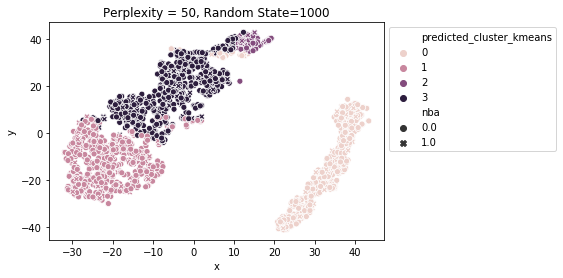

In [27]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the sam
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([cluster_one, df_tsne], axis=1)
dff['nba'] = cbb['nba']
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue='predicted_cluster_kmeans', style='nba', data=dff)
plt.title('Perplexity = 50, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/milesmathews70/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


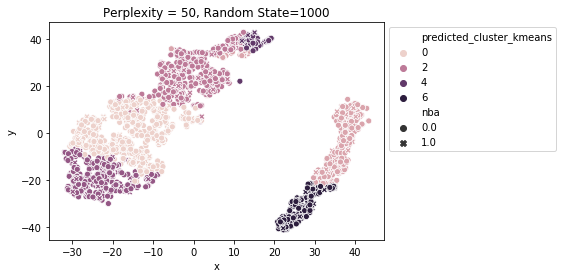

In [28]:
# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
data_tsne = tsne.fit_transform(X)
#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the sam
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([cluster_two, df_tsne], axis=1)
dff['nba'] = cbb['nba']
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue='predicted_cluster_kmeans', style='nba', data=dff)
plt.title('Perplexity = 50, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### 7.4. Assessing Clustering Separation and Cohesion

The average silhouette_score is : 0.36500597337210894


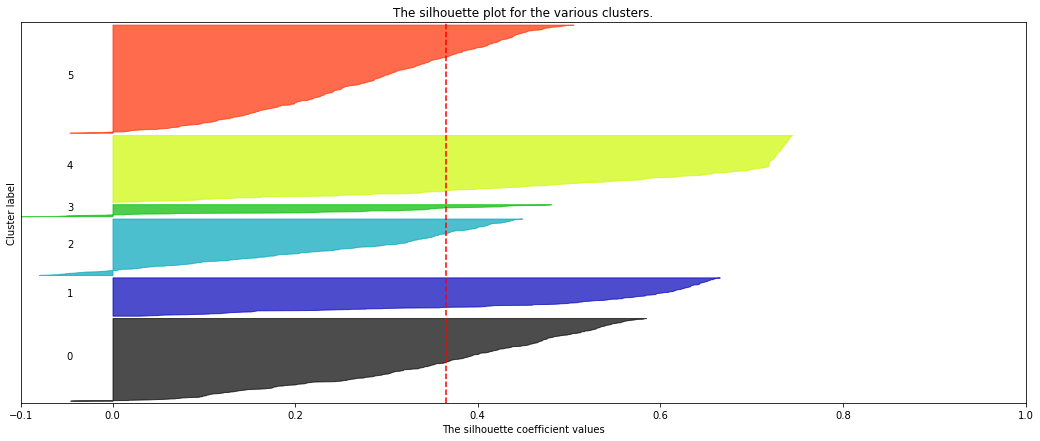

In [49]:
silhouette_avg = silhouette_score(X, cluster_two['predicted_cluster_kmeans'])

print("The average silhouette_score is :", silhouette_avg)

sample_silhouette_values = silhouette_samples(X, cluster_two['predicted_cluster_kmeans'])
n_clusters = 6


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])

ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

y_lower = 10

for i in range(n_clusters):

    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_two['predicted_cluster_kmeans'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
    facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

The silhuoette score is 0.365 which is very low. This means our clusters aren't very well-spaced apart and defined.

In addition, the interesting part is that clusters 0, 2, 3, and 5 have negative silhuoette values.

### 7.5. Additional Analysis

In [37]:
kmeans=KMeans(n_clusters=2).fit(X)

df['predicted_cluster_kmeans'] = kmeans.labels_

In [38]:
df['nba'] = cbb_copy['nba']

In [39]:
adjusted_rand_score(df['predicted_cluster_kmeans'],df['nba'])

-0.009533566161093562

In [40]:
homogeneity_score(df['nba'],df['predicted_cluster_kmeans'])

0.03244223523176175

In [41]:
completeness_score(df['nba'],df['predicted_cluster_kmeans'])

0.017095051699362537

In [43]:
v_measure_score(df['nba'],df['predicted_cluster_kmeans'])

0.02239128232036428

As we might expect from our prior analysis, we can't really cluster this data between 2 separate clusters as how we wanted to. There's too much nuance and randomness that can occur during NBA draft, and the statistics don't always tell the whole story.

### 7.6. Describing Each of the Clusters

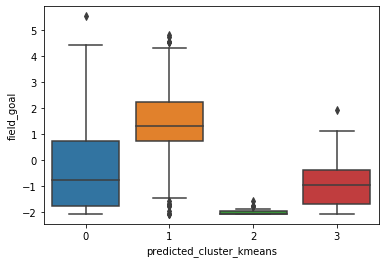

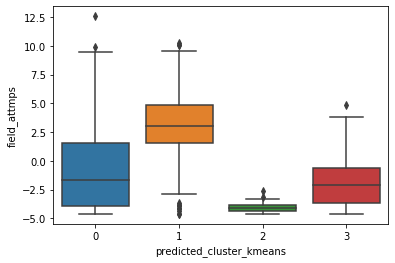

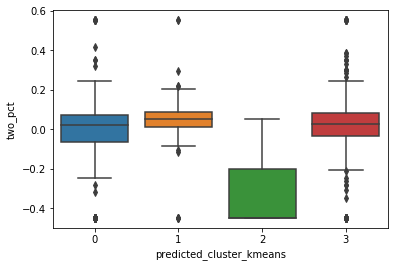

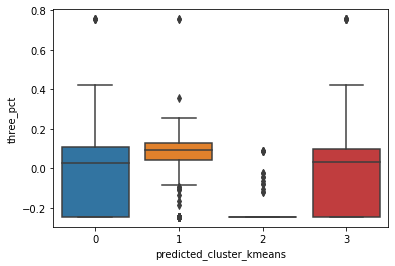

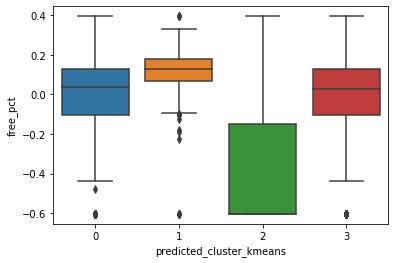

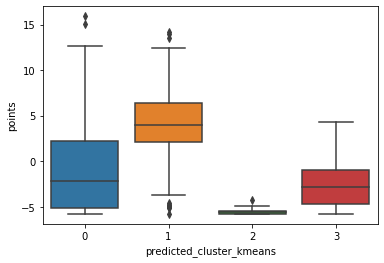

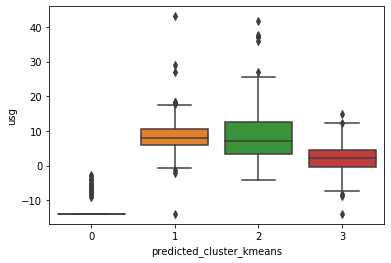

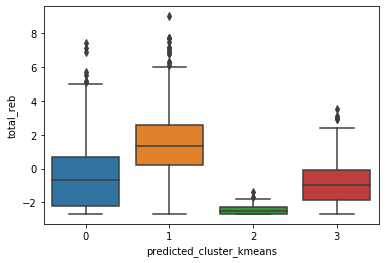

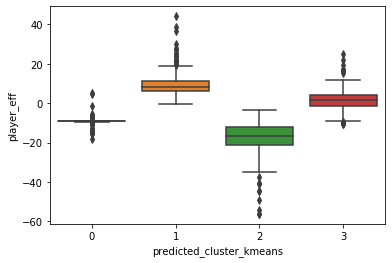

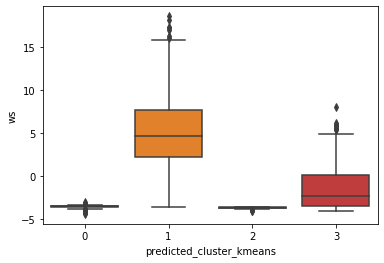

In [31]:
for col in sub_cols:
    sns.boxplot(x='predicted_cluster_kmeans', y=col, data=cluster_one)
    plt.show()

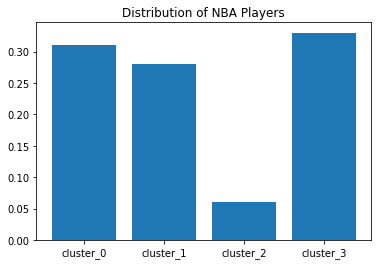

In [33]:
nbas = []
n = len(cbb_copy[cbb_copy['nba'] == 1])
cluster_one['nba'] = cbb_copy['nba']
for i in range(4):
    nbas.append(len(cluster_one[(cluster_one.nba == 1) & (cluster_one.predicted_cluster_kmeans == i)])/n)

plt.bar(range(4), nbas)
plt.xticks(range(4), ["cluster_" + str(i) for i in range(4)])
plt.title("Distribution of NBA Players")
plt.show()

In [37]:
guards = []
n_p = len(cbb[cbb['position'] == 'Guard'])
forwards = []
n_f = len(cbb[cbb['position'] == 'Forward'])
centers = []
n_c = len(cbb[cbb['position'] == 'Center'])
cluster_one['position'] = cbb['position']

for i in range(4):
    guards.append(len(cluster_one[(cluster_one.position == "Guard") & (cluster_one.predicted_cluster_kmeans == i)])/n_p)

for i in range(4):
    forwards.append(len(cluster_one[(cluster_one.position == "Forward") & (cluster_one.predicted_cluster_kmeans == i)])/n_f)
    
for i in range(4):
    centers.append(len(cluster_one[(cluster_one.position == "Center") & (cluster_one.predicted_cluster_kmeans == i)])/n_c)

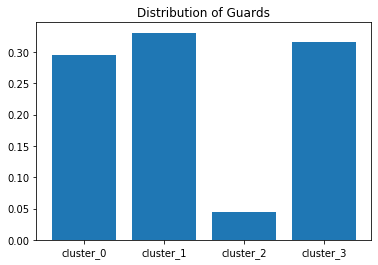

In [38]:
plt.bar(range(4), guards)
plt.xticks(range(4), ["cluster_" + str(i) for i in range(4)])
plt.title("Distribution of Guards")
plt.show()

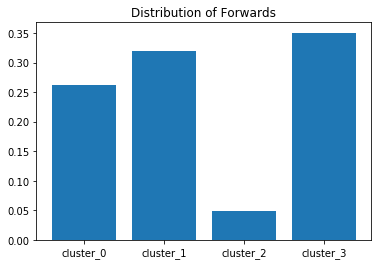

In [39]:
plt.bar(range(4), forwards)
plt.xticks(range(4), ["cluster_" + str(i) for i in range(4)])
plt.title("Distribution of Forwards")
plt.show()

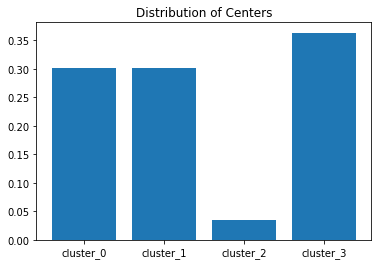

In [40]:
plt.bar(range(4), centers)
plt.xticks(range(4), ["cluster_" + str(i) for i in range(4)])
plt.title("Distribution of Centers")
plt.show()

I find this clustering interesting, but not super helpful. We can see that cluster 1 has the highest stats on average, but it doesn't really help that it only holds around 30% of the NBA players. Cluster 0 and 3 hold the other NBA players evenly, but the only statistic different between these is the win shares, where cluster 3 has higher win shares on average. Cluster 2 is somewhat obvious; it makes up the players who don't go to the league and aren't competent enough or decided to quit early.

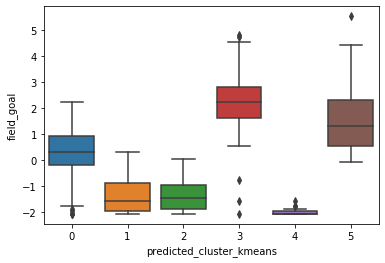

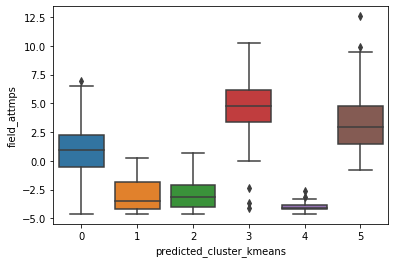

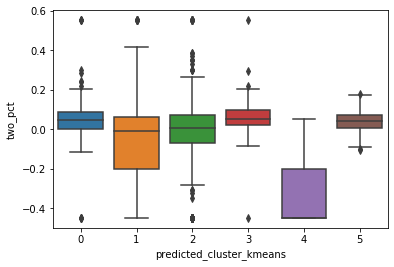

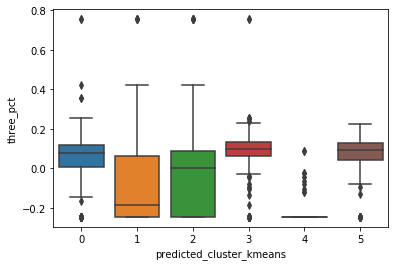

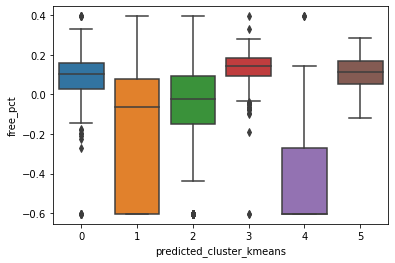

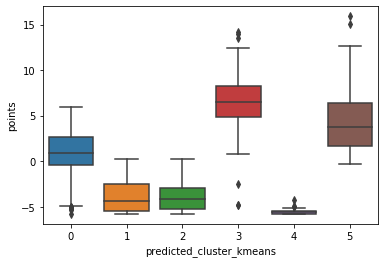

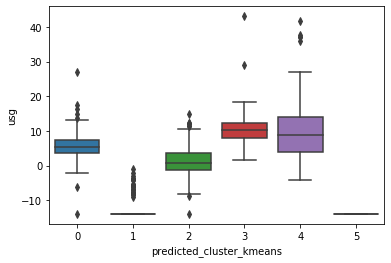

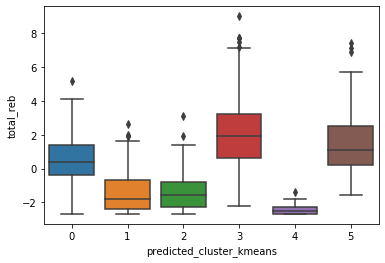

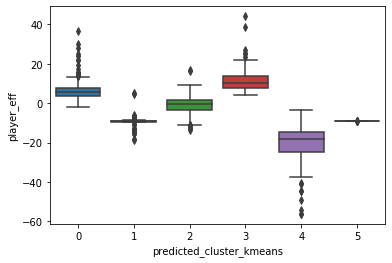

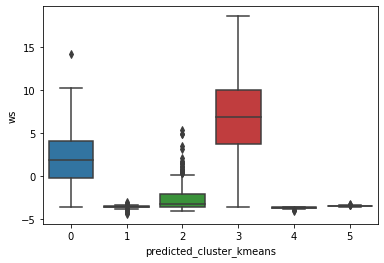

In [57]:
for col in sub_cols:
    sns.boxplot(x='predicted_cluster_kmeans', y=col, data=cluster_two)
    plt.show()

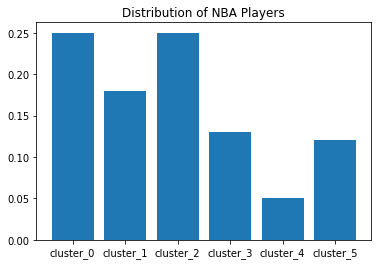

In [41]:
nbas = []
n = len(cbb_copy[cbb_copy['nba'] == 1])
cluster_two['nba'] = cbb_copy['nba']
for i in range(6):
    nbas.append(len(cluster_two[(cluster_two.nba == 1) & (cluster_two.predicted_cluster_kmeans == i)])/n)

plt.bar(range(6), nbas)
plt.xticks(range(6), ["cluster_" + str(i) for i in range(6)])
plt.title("Distribution of NBA Players")
plt.show()

In [51]:
guards = []
n_p = len(cbb[cbb['position'] == 'Guard'])
forwards = []
n_f = len(cbb[cbb['position'] == 'Forward'])
centers = []
n_c = len(cbb[cbb['position'] == 'Center'])
cluster_two['position'] = cbb['position']

for i in range(6):
    guards.append(len(cluster_two[(cluster_one.position == "Guard") & (cluster_two.predicted_cluster_kmeans == i)])/n_p)

for i in range(6):
    forwards.append(len(cluster_one[(cluster_two.position == "Forward") & (cluster_two.predicted_cluster_kmeans == i)])/n_f)
    
for i in range(6):
    centers.append(len(cluster_one[(cluster_two.position == "Center") & (cluster_two.predicted_cluster_kmeans == i)])/n_c)

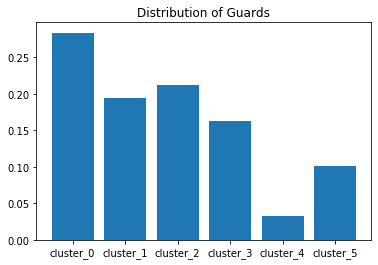

In [52]:
plt.bar(range(6), guards)
plt.xticks(range(6), ["cluster_" + str(i) for i in range(6)])
plt.title("Distribution of Guards")
plt.show()

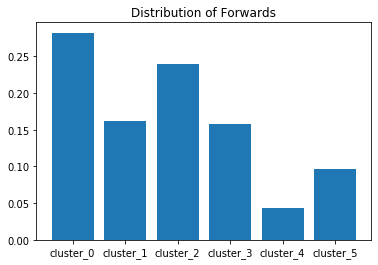

In [53]:
plt.bar(range(6), forwards)
plt.xticks(range(6), ["cluster_" + str(i) for i in range(6)])
plt.title("Distribution of Forwards")
plt.show()

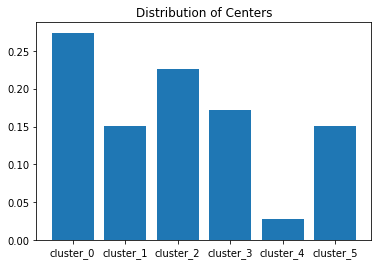

In [54]:
plt.bar(range(6), centers)
plt.xticks(range(6), ["cluster_" + str(i) for i in range(6)])
plt.title("Distribution of Centers")
plt.show()

From our 6 clusters we can see similar information, but a little bit more in-depth. Clusters 0 and 2 hold the most NBA players, but cluster 3 has the information we would see in a top NBA player. For example, a current favorite in the NBA, Devin Booker, is classified in label 3. Additionally, all of the stats between these three clusters always go to cluster 3 for the highest. This cluster could denote to the best college players that can have a huge impact on the game.

Clusters 0 and 2 hold the most NBA players in their clusters, but have very mediocre stats. Something to note though, is that there is a lot of Guards in cluster 0, and cluster 0 has somewhat higher stats than cluster 2 on average. This could mean more guards are being drafted into the league, and fill up this bucket of information.

To be specific, cluster 4 is the collection of non-NBA players. We can see that they have poor shooting stats, bad win shares, and bad play-making. What's interesting about this cluster is that it also houses very little data points, meaning these also could be players that we don't have much information on. For example, a student plays Division I basketball for 1 year, and then stops playing; now we have this player in our database with very low stats and we know almost nothing about.

In terms of overall skill on average, it goes cluster 3, cluster 0, cluster 2, cluster 4, cluster 5 (from most to least skill).

## 8. Clustering Algorithm 2 (change name to the algorithm you chose)



### 8.1. Parameter Selection

### 8.2. Clustering Algorithm

### 8.3. Clustering Algorithm Results Presentation

### 8.4. Assessing Clustering Separation and Cohesion

### 8.5. Additional Analysis

### 8.6. Describing Each of the Clusters

## 9. Analysis Summary and Conclusion

### 9.1. Algorithm Comparison Summary

#### 9.1.1. Comparing Algorithm Performance

Initially, we thought we were looking for NBA players in a specific cluster. And theorized we could evaluate the clustering with the different metrics we have available, however the information is very different. There are different types of NBA players that are translated from college players.  

#### 9.1.2. Comparing Algorithm Results

For K-Means results, we tried to put the data into two separate well-defined clusters, but unfortunately, our results for 2 clusters aren't very helpful to decide anything. But our 6 cluster algorithm showed interesting information. Rather of thinking about non-NBA and NBA, we can think of NBA players as levels. Where there are the talented, cream of the crop, NBA players and there are slightly worse, but still good players with varying stats.

### 9.2. Conclusion and Insights Summary

## 10. Group Contribution Report